In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer



In [9]:
# Lire les données
df = pd.read_csv("data.csv")

### Data Exploration

In [10]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
print(df.shape)
print(df.columns)

(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


### Data Correction

In [12]:
# Supprimer les colonnes inutiles
df.drop(
    [
        "Id",
        "ProductId",
        "UserId",
        "ProfileName",
        "HelpfulnessNumerator",
        "HelpfulnessDenominator",
        "Time",
    ],
    axis=1,
    inplace=True,
)

In [13]:
# Prétraitement des données textuelles
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [14]:
def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Tokenization des mots
    words = nltk.word_tokenize(text)
    # Suppression des caractères spéciaux, des mots vides et du mot "br"
    words = [word for word in words if word.isalnum() and word not in stop_words and word != "br"]
    # Lemmatisation des mots
    words = [lemmatizer.lemmatize(word) for word in words]
    # Reconstitution du texte prétraité
    processed_text = " ".join(words)
    return processed_text

df["ProcessedText"] = df["Text"][:100000].apply(preprocess_text)

### Text Visualization

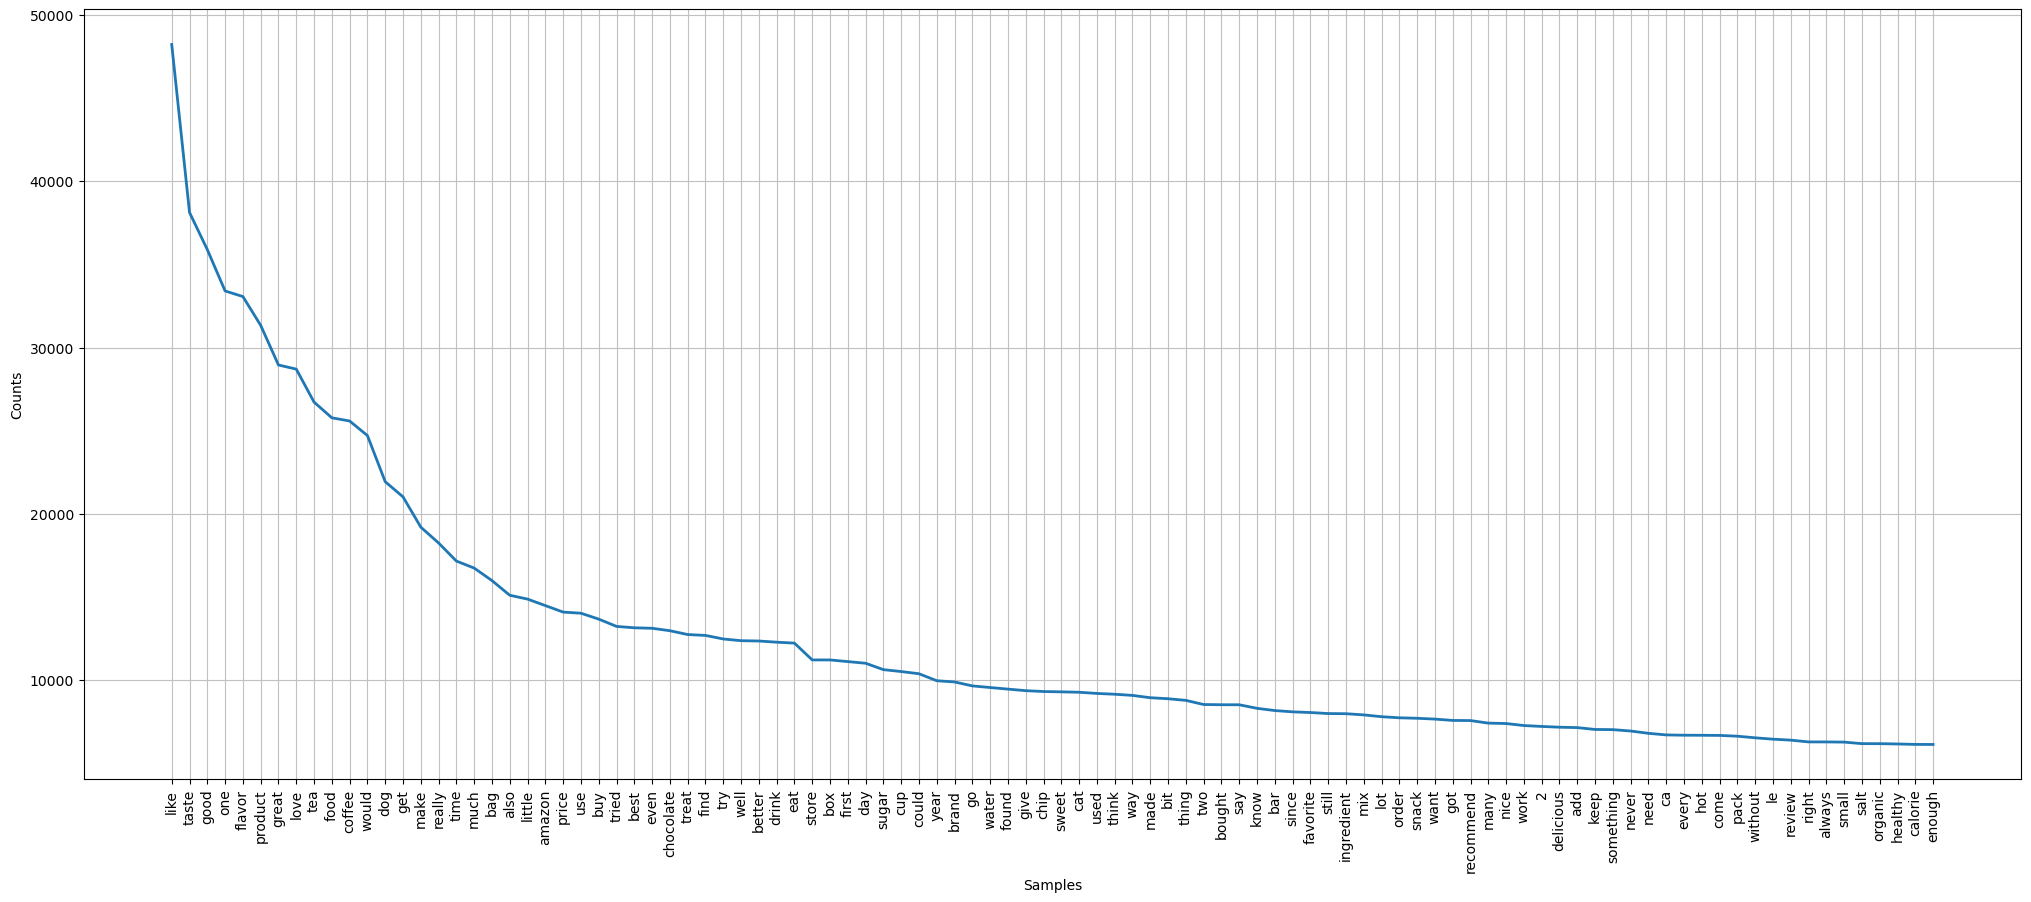

In [15]:
# Plot distribution de fréquence des mots
words = nltk.word_tokenize(df["ProcessedText"][:100000].str.cat(sep=" "))
fdist = FreqDist(words)
plt.figure(figsize=(25, 10))
fdist.plot(100, cumulative=False)
plt.show()

In [16]:
score_counts = df["Score"].value_counts() / len(df)

# Afficher les pourcentages des scores
print("Pourcentage des scores :")
for score in range(1, 6):
    percentage = score_counts[score] * 100
    print(f"Score {score}: {percentage:.2f}%")

# Sélectionner les 2 000 premières lignes pour chaque classe d'évaluation
df_1_star = df[df["Score"] == 1][:2000]
df_2_star = df[df["Score"] == 2][:2000]
df_3_star = df[df["Score"] == 3][:2000]
df_4_star = df[df["Score"] == 4][:2000]
df_5_star = df[df["Score"] == 5][:2000]

# Concaténer les DataFrames pour obtenir un tableau de 10 000 lignes
df_balanced = pd.concat([df_1_star, df_2_star, df_3_star, df_4_star, df_5_star])

# Mélanger les lignes du tableau
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)


Pourcentage des scores :
Score 1: 9.19%
Score 2: 5.24%
Score 3: 7.50%
Score 4: 14.19%
Score 5: 63.88%


Pourcentage des scores :
Score 1: 9.19%
Score 2: 5.24%
Score 3: 7.50%
Score 4: 14.19%
Score 5: 63.88%


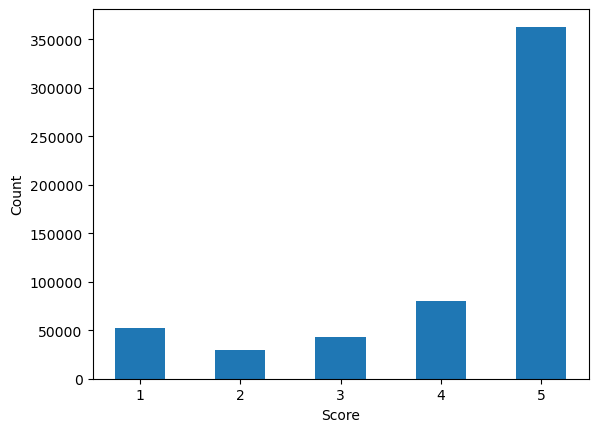

In [17]:
# Afficher les pourcentages des scores
print("Pourcentage des scores :")
for score in range(1, 6):
    percentage = score_counts[score] * 100
    print(f"Score {score}: {percentage:.2f}%")

# Visualiser la distribution des scores de sentiment
plt.hist(df["Score"], bins=[1, 2, 3, 4, 5, 6], align="left", rwidth=0.5)
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(range(1, 6))
plt.show()

In [18]:
# Fractionnement en sous-ensembles d'apprentissage et de test
X = df_balanced["ProcessedText"]
y = df_balanced["Score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
# Vectorisation des données textuelles
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [30]:
# Entraînement du modèle KNN Regression
knnRegression = KNeighborsRegressor(n_neighbors=30)
knnreg = knnRegression.fit(X_train, y_train)
y_pred = knnreg.predict(X_test)

In [31]:
# Evaluation des performances du modèle
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2 Score:", metrics.r2_score(y_test, y_pred))
print("Explained Variance Score:", metrics.explained_variance_score(y_test, y_pred))
print("Max Error:", metrics.max_error(y_test, y_pred))

Mean Absolute Error: 1.0156166666666666
Mean Squared Error: 1.444673888888889
Root Mean Squared Error: 1.20194587602308
R2 Score: 0.2644372698867543
Explained Variance Score: 0.2664060530649114
Max Error: 3.0999999999999996


        Predicted
Actual           
1        2.671029
2        2.854094
3        2.953779
4        3.181519
5        3.534568


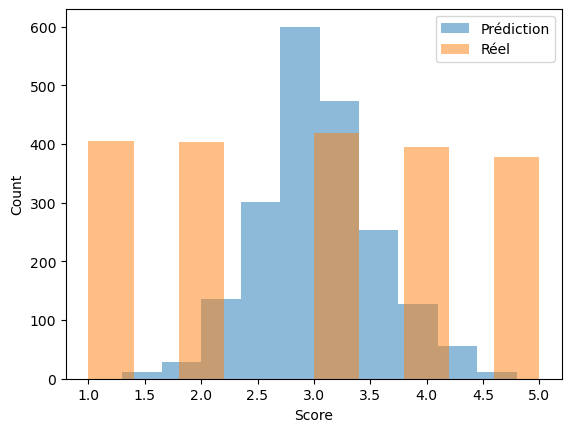

In [32]:
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

print(df.groupby("Actual").mean())

plt.hist(y_pred, alpha=0.5, label='Prédiction')
plt.hist(y_test, alpha=0.5, label='Réel')
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.show()
